In [4]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.offline as py
import matplotlib as plt

data = pd.read_csv('CaseCompetitionData.csv', sep=',')
data['actual'] = 1
data.loc[data['subsequent_purchases'] == 0, 'actual'] = 0
data = data.loc[(data['purchase_price'] !='?') & (data['customer_income'] != '?') & (data['customer_distance_to_dealer'] != '?')]
data.drop(columns=['post_purchase_satisfaction'], inplace=True)
data.head(5)


,insert_num,purchase_make,purchase_model,purchase_vehicle_year,purchase_price,trade_in,vehicle_financing,customer_age,customer_income,customer_gender,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,subsequent_purchases,actual
0,81690,DODGE,CHARGER,2010,10001 - 15000,0,0,21 - 30,20001 - 40000,U,0,9,1,0,0
1,109994,FORD,EXPLORER SPORT TRAC,2007,15001 - 20000,0,1,61 - 70,20001 - 40000,M,1,15,0,0,0
2,11399,BMW,328,2010,20001 - 25000,1,1,31 - 40,80001 - 100000,F,1,18,0,9,1
4,36685,CHEVROLET,CRUZE,2012,10001 - 15000,1,1,21 - 30,40001 - 60000,M,0,2,0,0,0
5,256143,MITSUBISHI,OUTLANDER SPORT,2011,15001 - 20000,0,1,21 - 30,40001 - 60000,M,0,12,0,0,0


In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import OrdinalEncoder

In [82]:
data[['purchase_make', 'purchase_model', 'purchase_price','customer_age', 'customer_income', 'customer_gender']] = data[['purchase_make', 'purchase_model', 'purchase_price', 'customer_age', 'customer_income', 'customer_gender']].astype('category')
data['purchase_make_cat'] = data['purchase_make'].cat.codes
data['purchase_model_cat'] = data['purchase_model'].cat.codes # mapping categoricals to numerical values
data['customer_age_cat'] = data['customer_age'].cat.codes
data['customer_income_cat'] = data['customer_income'].cat.codes
data['customer_income_cat'] = data['customer_income'].cat.codes
data['purchase_price_price'] = data['purchase_price'].cat.codes
data['customer_distance_to_dealer'] = pd.to_numeric(data['customer_distance_to_dealer'])
data.drop(columns=['purchase_make', 'purchase_model', 'purchase_price', 'customer_age', 'customer_income', 'customer_gender', 'subsequent_purchases', 'insert_num'], inplace=True)

In [77]:
features = data.drop(columns=['actual'])
labels = data['actual']
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)




In [5]:
rf = RandomForestClassifier()
scores = cross_val_score(rf, X_train, y_train.values.ravel(), cv=5)
print(scores)
parameters = {
    'n_estimators': [5, 50, 100],
    'max_depth': [2, 10, 20, None]
}

cv = GridSearchCV(rf, parameters, cv=5)
cv.fit(X_train, y_train.values.ravel())
print(cv.cv_results_)
print('BEST PARAMS: {}\n'.format(results.best_params_))

means = results.cv_results_['mean_test_score']
stds = results.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, results.cv_results_['params']):
    print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

C:\Users\999Na\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\999Na\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\999Na\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



KeyboardInterrupt: 

In [78]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5)
rf.fit(X_train, y_train)
scores = rf.score(X_val, y_val)
print(scores)
predictions = rf.predict_proba(X_test)
predictions2 = rf.predict(X_test)
print(metrics.accuracy_score(y_test, predictions2))
print(metrics.classification_report(y_test, predictions2, labels=[1,0]))
print(rf.feature_importances_)
print(X_test.columns)
print(metrics.confusion_matrix(y_test, predictions2, labels=[1,0]))

# looks like vehicle year, trade in, financing, previous purchase, distance, and warranty are most telling

0.6729626140903628
0.6750251729626141
              precision    recall  f1-score   support

           1       0.67      0.01      0.03     20153
           0       0.68      1.00      0.80     41421

    accuracy                           0.68     61574
   macro avg       0.67      0.51      0.42     61574
weighted avg       0.67      0.68      0.55     61574

[0.14452634 0.26476146 0.02430334 0.10588231 0.07958316 0.09579828
 0.01159819 0.01626662 0.01259106 0.03268895 0.21200031]
Index(['purchase_vehicle_year', 'trade_in', 'vehicle_financing',
       'customer_previous_purchase', 'customer_distance_to_dealer',
       'vehicle_warranty_used', 'purchase_make_cat', 'purchase_model_cat',
       'customer_age_cat', 'customer_income_cat', 'purchase_price_price'],
      dtype='object')
[[  279 19874]
 [  136 41285]]


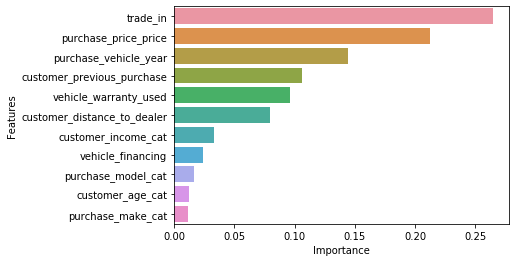

In [17]:
feat_imp = {'Importance':[0.14452634, 0.26476146, 0.02430334, 0.10588231, 0.07958316, 0.09579828,
 0.01159819, 0.01626662, 0.01259106, 0.03268895, 0.21200031], 'Features':['purchase_vehicle_year', 'trade_in', 'vehicle_financing',
       'customer_previous_purchase', 'customer_distance_to_dealer',
       'vehicle_warranty_used', 'purchase_make_cat', 'purchase_model_cat',
       'customer_age_cat', 'customer_income_cat', 'purchase_price_price']}
feat_imp = pd.DataFrame(feat_imp)
feat_imp.sort_values(by=['Importance'], ascending=False, inplace=True)
#feat_imp.to_csv('feat_imp.csv')
fig = sns.barplot(data=feat_imp, x='Importance', y='Features')
fig.figure.savefig('feat_imp.jpg')

20153
18616
56332
61574
0.3286918125157453
0.3272972358462988
[6157, 6157, 6157, 6157, 6157, 6157, 6157, 6157, 6157, 6161]


,purchase_vehicle_year,trade_in,vehicle_financing,customer_previous_purchase,customer_distance_to_dealer,vehicle_warranty_used,purchase_make_cat,purchase_model_cat,customer_age_cat,customer_income_cat,purchase_price_price,prob_yes,actual
295434,2008,0,1,0,5,0,5,334,2,7,1,0.299084,0
78292,2011,1,1,0,6,0,28,658,5,0,1,0.333697,0
143534,2011,1,1,0,71,0,9,257,3,1,5,0.336463,0
146514,2011,1,1,0,7,0,32,137,5,6,11,0.346843,1
199272,2011,0,1,0,7,1,28,504,3,8,2,0.306913,1


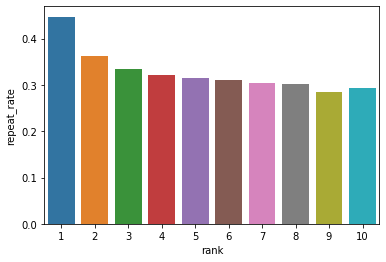

In [79]:
results = {'actual':y_test, 'prob_not':predictions[:,0], 'prob_yes':predictions[:,1]}
results = pd.DataFrame(results)
repeats = results[results['actual'] == 1]
print(len(repeats))
print(len(repeats[repeats['prob_yes'] >= .3]))
print(len(results[results['prob_yes'] >= .3]))
print(len(results))
print(results['prob_yes'].mean())
x = round(len(results)/10)

recreate = X_test
recreate['prob_yes'] = predictions[:,1]
recreate['actual'] = y_test
print(recreate['actual'].mean())

results.sort_values(by=['prob_yes'], ascending=False, inplace=True)
results.reset_index(inplace=True)
results.rename(columns={'index':'customer'}, inplace=True)
results
rank = []
repeat_rate = []
sales_rank_probs = []
lengths = []

for num in range(1,11):
    if num == 10:
        y = results.iloc[x*(num-1):]
        rr = len(results.iloc[x*(num-1):])
    else:
        y = results.iloc[x*(num-1):x*num]
        rr = len(results.iloc[x*(num-1):x*num])
    z = y['actual'].sum()/len(y)
    sales_rank_probs.append(results.iloc[x*(num-1)]['prob_yes'])
    rank.append(num)
    repeat_rate.append(z)
    lengths.append(rr)

sales_rank_probs.append(0)
sales_rank = {'rank':rank, 'repeat_rate':repeat_rate}
sales_rank = pd.DataFrame(sales_rank)
print(lengths)
sales_rank.head(10)

sns.barplot(x='rank', y='repeat_rate', data=sales_rank)
recreate.head()

In [84]:
features = data.drop(columns=['actual'])
labels = data['actual']
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [85]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
rf = RandomForestClassifier(n_estimators=100, max_depth=5)
rf.fit(X_train,y_train)
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])


In [86]:
logit__roc_auc1 = roc_auc_score(y_test, rf.predict(X_test))


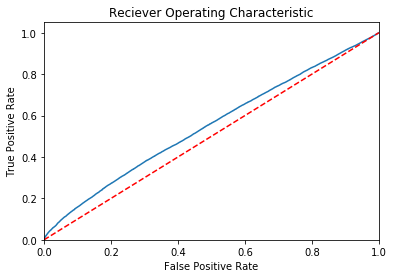

In [87]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (Sensitivity = %0.3f)' % logit__roc_auc1)
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1.0])
plt.ylim([0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Reciever Operating Characteristic')
plt.show()

In [5]:
data = pd.read_csv('CaseCompetitionData.csv', sep=',')
data['actual'] = 1
data.loc[data['subsequent_purchases'] == 0, 'actual'] = 0
data['customer_age'] = data['customer_age'].map({'21 - 30':25, '61 - 70':65, '31 - 40':35, '41 - 50':45, '51 - 60':55, '101+':102, '71 - 80':75,
 '0 - 20':10, '81 - 90':85, '?':'?', '91 - 100':95})
data['customer_income'] = data['customer_income'].map({'20001 - 40000':30000, '80001 - 100000':90000, '40001 - 60000':50000, '60001 - 80000':70000,
 '120001 - 140000':130000, '0 - 20000':10000, '100001 - 120000':110000, '160001 - 180000':170000,
 '200001+':220000, '140001 - 160000':150000, '180001 - 200000':190000, '?':'?'})
data['purchase_price'] = data['purchase_price'].map({'10001 - 15000':12500, '15001 - 20000':17500, 
 '20001 - 25000':22500, '25001 - 30000':27500, '30001 - 35000':32500, '0 - 5000':2500, '45001 - 50000':47500, 
 '35001 - 40000':27500, '5001 - 10000':7500, '40001 - 45000':47500, '55001 - 60000':57500, '50001 - 55000':52500, 
 '60001 - 65000':62500, '65001 - 70000':67500, '70001 - 75000':72500, '75001 - 80000':77500, '85001 - 90000':87500,
 '90001 - 95000':92500, '80001 - 85000':82500, '?':'?'})
data['counter'] = 1
price = data.loc[data['purchase_price'] != '?']
income = data.loc[data['customer_income'] != '?']
distance = data.loc[data['customer_distance_to_dealer'] != '?']
age = data.loc[data['customer_age'] != '?']
print(len(price))
print(len(income))
print(len(distance))
print(len(age))

361556
312468
355397
360405


0.3417284592556125


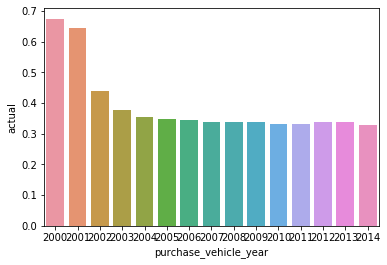

In [167]:
subs = data.loc[data['purchase_vehicle_year'] >= 2000]
#sns.violinplot(x=subs['actual'], y=subs['purchase_vehicle_year']) # checking distribution of car year models against whether they are repeat customers
#looks like a rather similar distribution so this might not be entirely too telling

subs_ratio = data.loc[data['purchase_vehicle_year'] >= 2000].groupby('purchase_vehicle_year')['actual'].mean().to_frame().reset_index()
print(data['actual'].mean())
sns.barplot(x='purchase_vehicle_year', y='actual', data=subs_ratio)


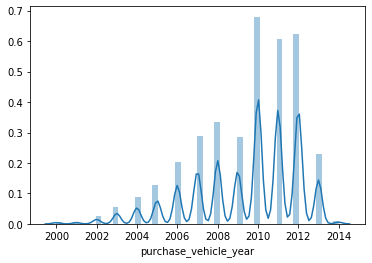

In [168]:
sns.distplot(data.loc[data['purchase_vehicle_year'] >=2000]['purchase_vehicle_year'])

0.3417284592556125


,purchase_price,actual
0,2500,0.665311
1,7500,0.374938
2,12500,0.333195
3,17500,0.334793
4,22500,0.337249
5,27500,0.342182
6,32500,0.340382
7,47500,0.369987
8,52500,0.365639
9,57500,0.420213


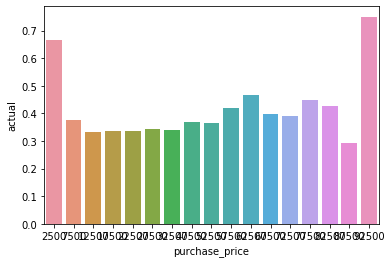

In [169]:
purch_ratio = price.groupby('purchase_price')['actual'].mean().to_frame().reset_index()
print(data['actual'].mean())
sns.barplot(x='purchase_price', y='actual', data=purch_ratio)
purch_ratio

#fig = px.pie(data, values='actual', names='purchase_price', title='Subsequent Buyers Purchase Price')
#py.offline.plot(fig, filename='purchase_price_breakdown.html', auto_open=True)

,purchase_price,actual
0,2500,2944
1,7500,3764
2,12500,33753
3,17500,39607
4,22500,22396
5,27500,13560
6,32500,5199
7,47500,1716
8,52500,249
9,57500,158


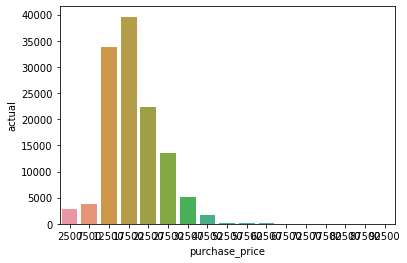

In [170]:
purch = price.loc[data['actual'] == 1].groupby('purchase_price')['actual'].sum().to_frame().reset_index()
sns.barplot(x='purchase_price', y='actual', data=purch)
purch

,purchase_price,insert_num
0,2500,4425
1,7500,10039
2,12500,101301
3,17500,118303
4,22500,66408
5,27500,39628
6,32500,15274
7,47500,4638
8,52500,681
9,57500,376


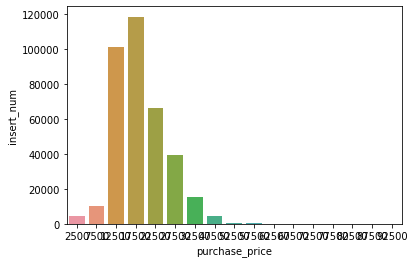

In [171]:
purch_dist = price.groupby('purchase_price')['insert_num'].count().to_frame().reset_index()
sns.barplot(x='purchase_price', y='insert_num', data=purch_dist)
purch_dist

1154
   customer_age  actual
0            10    6343
1            25   84906
2            35   89749
3            45   85678
4            55   55469
5            65   26325
6            75    8217
7            85    2243
8            95     164
9           102    1311


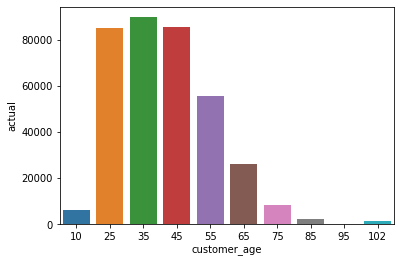

In [172]:
print(len(data[data['customer_age'] == '?'])) # only a couple people have unknown ages
age_counts = age.groupby('customer_age')['actual'].count().to_frame().reset_index()
print(age_counts.head(10))
sns.barplot(x='customer_age', y='actual', data=age_counts)


1154

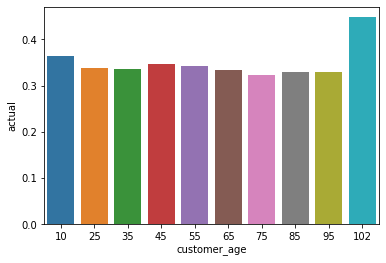

In [173]:
age_buckets = age.groupby('customer_age')['actual'].mean().to_frame().reset_index()
sns.barplot(x='customer_age', y='actual', data=age_buckets)
#interesting that 101+ stands out as a higher liklihood to be a repeat
age_buckets.head()
len(data['customer_age'])-len(data[data['customer_age'] != '?'])
#data[data['customer_age'] == '?'].head(25)


In [174]:
trade_in = data.groupby('trade_in')['actual'].mean().to_frame().reset_index()
print(trade_in.head())
customer_previous_purchase = data.groupby('customer_previous_purchase')['actual'].mean().to_frame().reset_index()
print(customer_previous_purchase.head())
warranty_used = data.groupby('vehicle_warranty_used')['actual'].mean().to_frame().reset_index()
print(warranty_used.head())
financing = data.groupby('vehicle_financing')['actual'].mean().to_frame().reset_index()
print(financing.head())

   trade_in    actual
0         0  0.322550
1         1  0.363858
   customer_previous_purchase    actual
0                           0  0.329577
1                           1  0.387068
   vehicle_warranty_used    actual
0                      0  0.335684
1                      1  0.359969
   vehicle_financing    actual
0                  0  0.370446
1                  1  0.333032


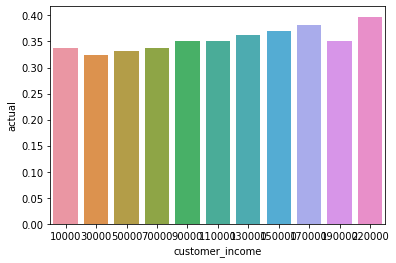

In [175]:
cust_income = income.groupby('customer_income')['actual'].mean().to_frame().reset_index()
sns.barplot(x='customer_income', y='actual', data=cust_income)

In [176]:
age['customer_age'] = pd.to_numeric(age['customer_age'])
distance['customer_distance_to_dealer'] = pd.to_numeric(distance['customer_distance_to_dealer'])                                          

C:\Users\999Na\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\999Na\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [177]:
par_cats = data[['actual', 'trade_in']]
par_cats.dtypes
fig = px.parallel_categories(par_cats)
py.offline.plot(fig, filename='parallel_cats.html', auto_open=True)

'parallel_cats.html'

In [178]:
par_cats = data[['actual', 'vehicle_financing']]
par_cats.dtypes
fig = px.parallel_categories(par_cats)
py.offline.plot(fig, filename='parallel_cats.html', auto_open=True)

'parallel_cats.html'

In [225]:
par_cats = data[['actual', 'customer_previous_purchase']]
par_cats.dtypes
fig = px.parallel_categories(par_cats)
py.offline.plot(fig, filename='parallel_cats.html', auto_open=True)

'parallel_cats.html'

In [180]:
par_cats = data[['actual', 'vehicle_warranty_used']]
par_cats.dtypes
fig = px.parallel_categories(par_cats)
py.offline.plot(fig, filename='parallel_cats.html', auto_open=True)

'parallel_cats.html'

In [181]:
purchase_year = data.loc[data['purchase_vehicle_year'] >= 2000].groupby(['trade_in', 'purchase_vehicle_year'])['actual'].mean().to_frame().reset_index()
purchase_year
fig = px.bar(purchase_year, x='purchase_vehicle_year', y='actual', facet_row='trade_in')
py.offline.plot(fig, 'year_previous.html', auto_open=True)

'temp-plot.html'

In [234]:
par_cats = price.loc[price['purchase_vehicle_year'] >= 2000][['actual', 'purchase_vehicle_year', 'trade_in']]
print(par_cats['purchase_vehicle_year'].unique())
fig = px.parallel_categories(par_cats)
py.offline.plot(fig, filename='parallel_cats.html', auto_open=True)

[2010 2007 2008 2012 2011 2005 2013 2006 2004 2009 2002 2003 2014 2001
 2000]


'parallel_cats.html'

In [182]:
income_trade = income.groupby(['customer_income', 'trade_in'])['actual'].mean().to_frame().reset_index()
purchase_year
fig = px.bar(income_trade, x='customer_income', y='actual', facet_row='trade_in')
py.offline.plot(fig, 'income_trade.html', auto_open=True)

'temp-plot.html'

In [183]:
price_trade = price.groupby(['purchase_price', 'trade_in'])['actual'].mean().to_frame().reset_index()
purchase_year
fig = px.bar(price_trade, x='purchase_price', y='actual', facet_row='trade_in')
py.offline.plot(fig, 'price_trade.html', auto_open=True)
data['actual'].mean()

0.3417284592556125

In [184]:
age_trade = age.groupby(['customer_age', 'trade_in'])['actual'].mean().to_frame().reset_index()
purchase_year
fig = px.bar(age_trade, x='customer_age', y='actual', facet_row='trade_in')
py.offline.plot(fig, 'age_trade.html', auto_open=True)
data['actual'].mean()

0.3417284592556125

In [185]:
dist_trade = distance.groupby(['customer_distance_to_dealer', 'trade_in'])['actual'].mean().to_frame().reset_index()
purchase_year
fig = px.bar(dist_trade, x='customer_distance_to_dealer', y='actual', facet_row='trade_in')
py.offline.plot(fig, 'dist_trade.html', auto_open=True)


'temp-plot.html'

In [186]:
make_trade = data.groupby(['purchase_make', 'trade_in'])['actual'].mean().to_frame().reset_index()
fig = px.bar(make_trade, x='purchase_make', y='actual', facet_row='trade_in')
py.offline.plot(fig, 'make_trade.html', auto_open=True)

'temp-plot.html'

In [187]:
make_prev = data.groupby(['purchase_make', 'customer_previous_purchase'])['actual'].mean().to_frame().reset_index()
fig = px.bar(make_prev, x='purchase_make', y='actual', facet_row='customer_previous_purchase')
py.offline.plot(fig, 'make_prev.html', auto_open=True)

'temp-plot.html'

In [6]:
make_fin = data.groupby(['purchase_make', 'vehicle_financing'])['actual'].mean().to_frame().reset_index()
fig = px.bar(make_fin, x='purchase_make', y='actual', facet_row='vehicle_financing')
py.offline.plot(fig, 'make_fin.html', auto_open=True)

'temp-plot.html'

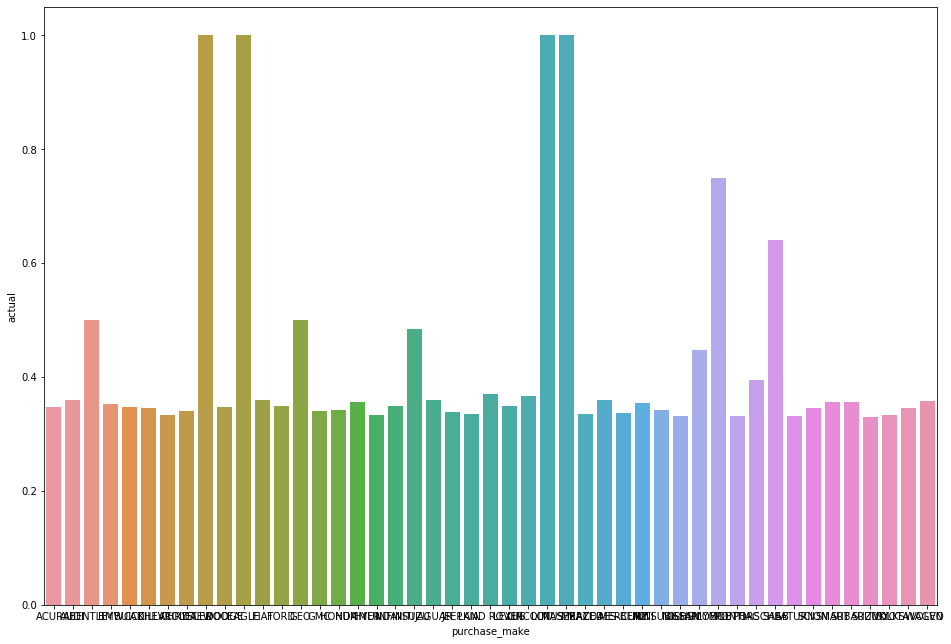

In [189]:
makes = data.groupby('purchase_make')['actual'].mean().to_frame().reset_index()
plt.figure(figsize=(16,11))
sns.barplot(x='purchase_make', y='actual', data=makes)


In [1]:
makes = data
makes['counter'] = 1
makes = makes.groupby('purchase_make')['counter'].sum().to_frame().reset_index()
print(makes['actual'].mean())
low_demand = makes.loc[makes['counter'] < 2000]
low_make = data.loc[data.purchase_make.isin(low_demand['purchase_make'].unique())].groupby('purchase_make')['actual'].mean().to_frame().reset_index()
sns.barplot(x='purchase_make', y='actual', data=low_make)
print(low_make['actual'].mean())
#low_make.to_csv()

NameError: name 'data' is not defined

In [191]:
warranty_price = price.groupby(['vehicle_warranty_used', 'purchase_price'])['actual'].mean().to_frame().reset_index()
fig = px.bar(warranty_price, x='purchase_price', y='actual', facet_row='vehicle_warranty_used')
py.offline.plot(fig, 'warranty_price.html', auto_open=True)

'temp-plot.html'

In [192]:
warranty_year = data.loc[data['purchase_vehicle_year'] >= 2000].groupby(['vehicle_warranty_used', 'purchase_vehicle_year'])['actual'].mean().to_frame().reset_index()
fig = px.bar(warranty_year, x='purchase_vehicle_year', y='actual', facet_row='vehicle_warranty_used')
py.offline.plot(fig, 'warranty_year.html', auto_open=True)


'temp-plot.html'

In [202]:
warranty_year = data.loc[data['purchase_vehicle_year'] >= 2000]#.groupby(['vehicle_warranty_used', 'purchase_vehicle_year'])['counter'].sum().to_frame().reset_index()
#warranty_year.head()
fig = px.histogram(warranty_year, x='purchase_vehicle_year', y='counter', facet_row='vehicle_warranty_used')
py.offline.plot(fig, 'warranty_price_dist.html', auto_open=True)

'temp-plot.html'

In [193]:
warranty_income = income.groupby(['vehicle_warranty_used', 'customer_income'])['actual'].mean().to_frame().reset_index()
fig = px.bar(warranty_income, x='customer_income', y='actual', facet_row='vehicle_warranty_used')
py.offline.plot(fig, 'warranty_income.html', auto_open=True)

'temp-plot.html'

In [194]:
warranty_age = age.groupby(['vehicle_warranty_used', 'customer_age'])['actual'].mean().to_frame().reset_index()
fig = px.bar(warranty_age, x='customer_age', y='actual', facet_row='vehicle_warranty_used')
py.offline.plot(fig, 'warranty_age.html', auto_open=True)

'temp-plot.html'

In [212]:
price_year = price.loc[price['purchase_vehicle_year'] > 2000].groupby(['purchase_vehicle_year', 'purchase_price'])['actual'].mean().to_frame().reset_index()
fig = px.bar(price_year, x='purchase_price', y='actual', facet_row='purchase_vehicle_year', width=1600, height=1600)
py.offline.plot(fig, 'price_year.html', auto_open=True)

'temp-plot.html'

In [227]:
par_cats = price[['actual', 'purchase_price']]
par_cats.dtypes
fig = px.parallel_categories(par_cats)
py.offline.plot(fig, filename='parallel_cats.html', auto_open=True)

'parallel_cats.html'

In [224]:
price_year = price.loc[data['purchase_vehicle_year'] >= 2000].groupby(['purchase_vehicle_year', 'purchase_price'])['counter'].sum().to_frame().reset_index()
price_year.head(-25)
#fig = px.bar(price_year, x='purchase_price', y='counter', facet_row='purchase_vehicle_year', width=400, height=1600)
#py.offline.plot(fig, 'price_year_dist.html', auto_open=True)

,purchase_vehicle_year,purchase_price,counter
0,2000,2500,597
1,2000,7500,75
2,2000,12500,16
3,2000,17500,2
4,2000,27500,1
...,...,...,...
138,2012,67500,51
139,2012,72500,26
140,2012,77500,12
141,2012,82500,2
